## Модульное ДЗ1, вариант 7
### Панков Викентий

1. Данные var7.tsv.
2. Промоделируйте выборку из $N(a, \sigma^2)$ (параметры $a$ и $\sigma$ могут быть любыми) объема $N = 150$. Посмотрите на выборочную медиану и выборочное среднее. Затем промоделируйте выборку из $N(a + 5\sigma, \sigma^2)$ объема $N = 5$ и добавьте эти наблюдения в исходную выборку.

    - Повторите моделирование (150 наблюдений из одного распределения и 5 из другого) несколько раз и исследуйте смещение среднего и медианы относительно $a$.

    - Исследуйте поведение дисперсии выборочного среднего и выборочной медианы и сравните их поведение.

3. Известно, что дисперсия распределения Бернулли равна $p(1 − p)$. Для построения доверительного интервала можно использовать следующее неравенство:

    $z_1 < \sqrt{n}*\frac{\overline{x} - p}{\sqrt{p(1-p)}} < z_2$

    где $z_1$ и $z_2$ — соответствующие квантили. Выпишите явное решение неравенства относительно параметра $p$ и с его помощью постройте доверительный интервал для параметра $p$.
4. Рассмотрим последовательность случайных величин $\xi_n ∈ Bin(n, p_n)$. Пусть $np_n \to \lambda > 0$ при $n \to ∞$. Продемонстрируйте выполнение теоремы Пуассона:
    $P(\xi_n = k) \xrightarrow[n \to \infty]{} \pi_k = \frac{\lambda^k e^{-\lambda}}{k!}, k = 0,1,2,\dots$
    (Таким образом, случайная величина $\xi_n$ имеет асимптотически распределение Пуассона с параметром $\lambda$).

## 1. Разведочный анализ данных

In [10]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline 
sns.set(color_codes=True)

df = pd.read_csv("var7.tsv",sep='\t')
df.head()

,Age,Weight,Height,Waist,Hip,Thigh
0,23,154.25,67.75,33.543307,94.5,59.0
1,22,173.25,72.25,32.677165,98.7,58.7
2,22,154.00,66.25,34.606299,99.2,59.6
3,26,184.75,72.25,34.015748,101.2,60.1
4,24,184.25,71.25,39.370079,101.9,63.2


**Построим графики распределений показателей:**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb8da0703d0>,
      dtype=object)

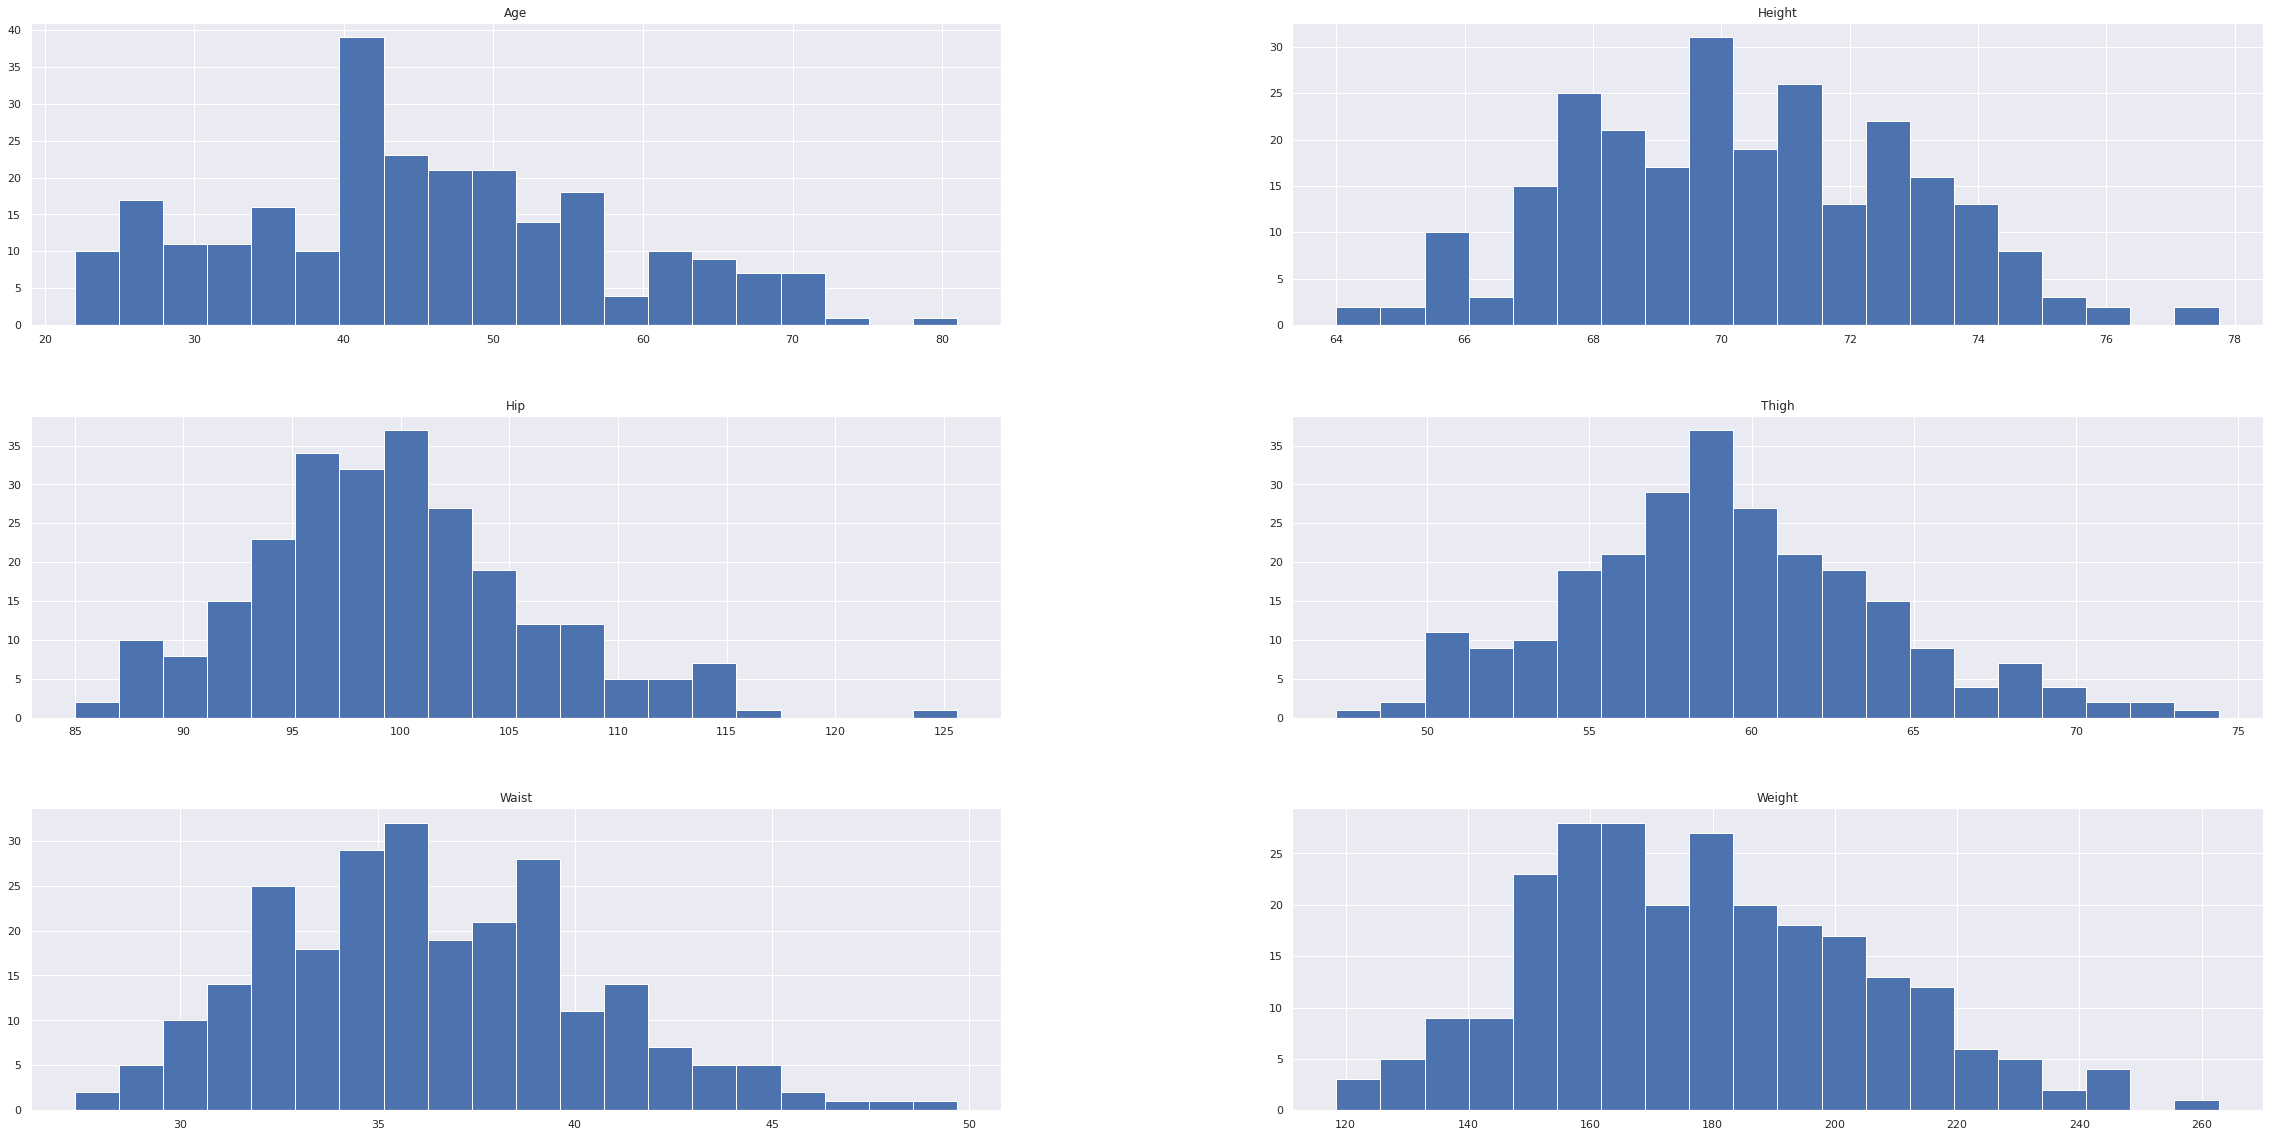

In [11]:
df.hist(bins=20, layout=(3,2), figsize=(40,20))

**Посмотрим на корреляцию показателей: **

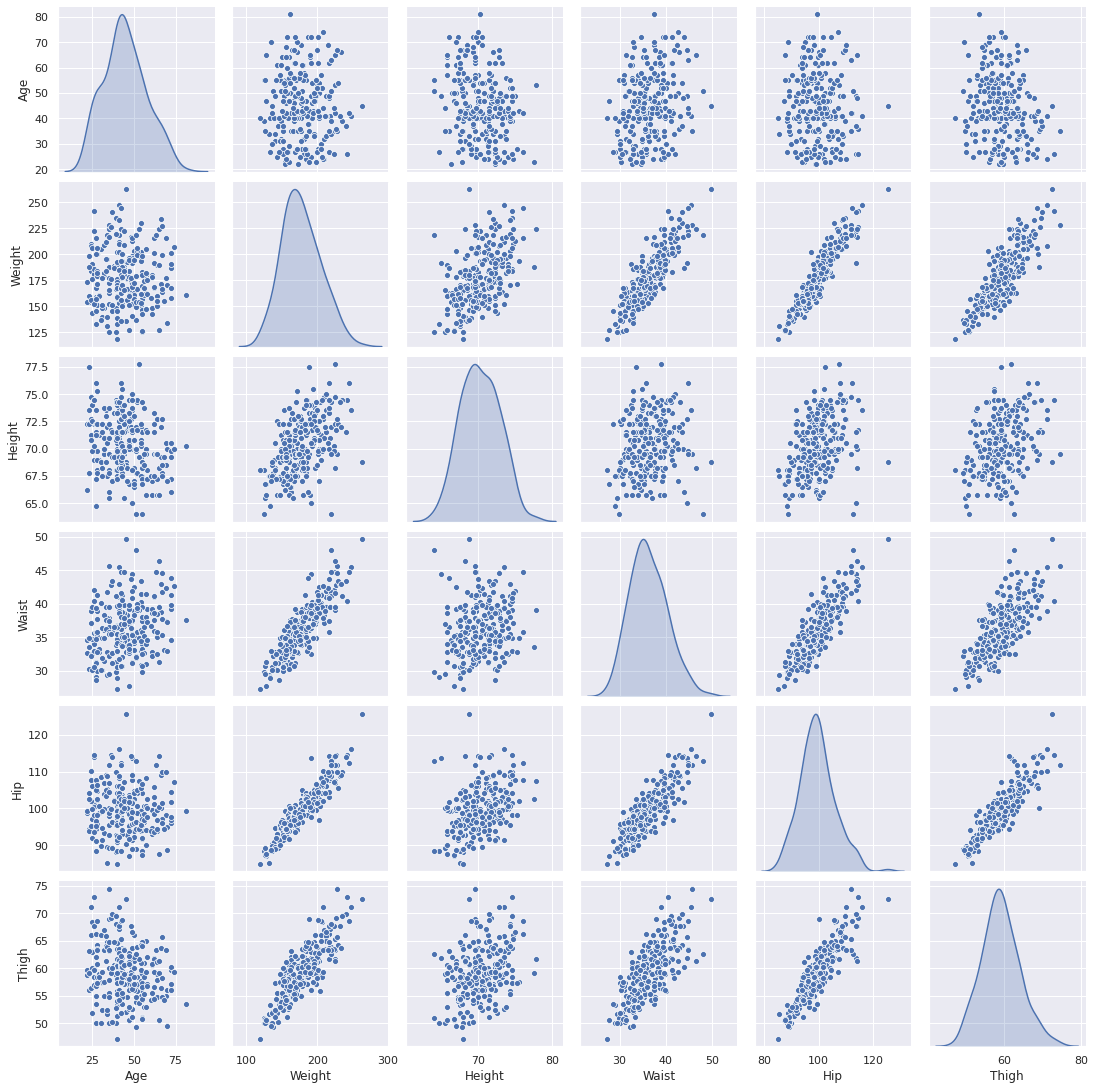

In [12]:
sns.pairplot(df, diag_kind='kde')


In [346]:
df.describe() #выведем основные характеристики

,Age,Weight,Height,Waist,Hip,Thigh
count,250.000000,250.000000,250.000000,250.000000,250.000000,250.000000
mean,44.884000,178.083200,70.303000,36.333386,99.651200,59.249600
std,12.652227,27.035488,2.616644,4.018679,6.443634,4.912309
min,22.000000,118.500000,64.000000,27.322835,85.000000,47.200000
25%,35.250000,158.500000,68.250000,33.277559,95.500000,56.000000
50%,43.000000,176.125000,70.000000,35.787402,99.300000,58.950000
75%,54.000000,196.750000,72.250000,39.045276,103.175000,62.250000
max,81.000000,262.750000,77.750000,49.685039,125.600000,74.400000


- Все показатели похожи на выборки из нормальных распределений
- Между многими показателями имеются выраженные прямые зависимости. Например, между весом (Weight) и размером бедра (Hip). Для Age (возраста) связи с другими показателями не замечено

** Построим boxplot, чтобы обнаружить выбросы: **

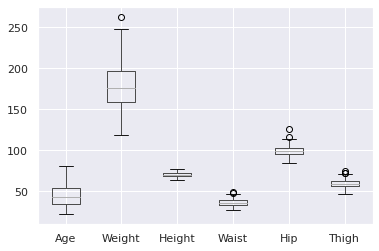

In [21]:
df.boxplot()

Можно предположить, что есть выбросы в данных по весу, охвату талии, охвату бедра, бедренной кости

Выведем их с помощью фильтрации по интерквартильному размаху:

In [58]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

#Выброс по весу
print(df.Weight[((df < (Q1-2 * IQR)) |(df > (Q3 + 2 * IQR))).any(axis=1)])

#Выброс по охвату талии
print(df.Waist[((df < (Q1-2 * IQR)) |(df > (Q3 + 2 * IQR))).any(axis=1)])

#Выброс по охвату бедра
print(df.Hip[((df < (Q1-2 * IQR)) |(df > (Q3 + 2 * IQR))).any(axis=1)])

#Выброс по охвату бедренной кости
print(df.Thigh[((df < (Q1-2 * IQR)) |(df > (Q3 + 2 * IQR))).any(axis=1)])

39    262.75
Name: Weight, dtype: float64
39    49.685039
Name: Waist, dtype: float64
39    125.6
Name: Hip, dtype: float64
39    72.5
Name: Thigh, dtype: float64


** Это всё одно наблюдение. Тяжелый человек оказался также и с большими охватом талии, бедра, бедренной кости **

## 2. Смоделируем выборку из нормального распределения

In [66]:
def getMeansMedians(a, d, N, repeat_count, print_vals = False):

    sample = np.random.normal(loc=a, scale=d, size=N)

    if(print_vals):
        print(f"Выборочная медиана: {np.quantile(sample, 0.5)}")
        print(f"Выборочное среднее: {np.mean(sample)}")


    noise_sample = np.random.normal(loc=a+5*d, scale=d, size=5)

    means = []
    medians = []

    means_errors = []

    for i in range(0, repeat_count):
        sample = np.random.normal(loc=a, scale=d, size=N)
        noise_sample = np.random.normal(loc=a+5*d, scale=d, size=5)
        sample_with_noise = np.concatenate([sample, noise_sample])
        means.append(sample_with_noise.mean())
        medians.append(np.median(sample_with_noise))

    return means, medians

means, medians = getMeansMedians(a = 4.3, d = 2.55, N = 150, repeat_count = 1000, print_vals = True)

print(f"Смещение выборочного среднего для выборки с шумом 2: {np.mean(means) - a}")
print(f"Смещение медианы для выборки с шумом: {np.mean(medians) - a}")

print(f"Дисперсия выборочного среднего: {np.var(means)}")
print(f"Дисперсия выборочной медианы: {np.var(medians)}")

Выборочная медиана: 4.2333148565579855
Выборочное среднее: 4.270830583756308
Смещение выборочного среднего для выборки с шумом 2: 0.41096582146039484
Смещение медианы для выборки с шумом: 0.10543316927441992
Дисперсия выборочного среднего: 0.04143696251183711
Дисперсия выборочной медианы: 0.07063675607662824


** Смоделируем порядок сходимости дисперсий медианы и выборочного среднего: **



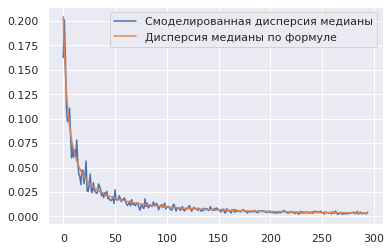

In [86]:
d = 2.55

mean_vars = []
median_vars = []
convOrder = []
convOrderMedian = []

for nx in range(5, 300):
    N = nx * 10
    means, medians = getMeansMedians(a = 4.3, d = 2.55, N = N, repeat_count = 50)
    mean_vars.append(np.var(means))
    median_vars.append(np.var(medians))
    convOrder.append(d**2/N) 
    convOrderMedian.append(np.pi*d**2/(2*N)) 

plt.plot(median_vars)
plt.plot(convOrderMedian)
plt.legend(["Смоделированная дисперсия медианы", "Дисперсия медианы по формуле"])

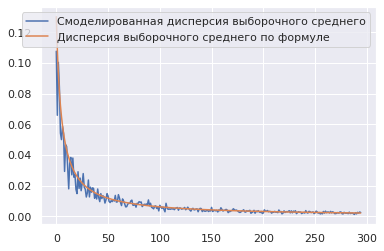

In [85]:
plt.plot(mean_vars)
plt.plot(convOrder)
plt.legend(["Смоделированная дисперсия выборочного среднего", "Дисперсия выборочного среднего по формуле"])

** Видим, что порядок сходимости дисперсий выборочного среднего и медианы линейный $(1/N)$ **

Построим график для дисперсий выборочного среднего и медианы по истинным формулам для дисперсий выборочного среднего и медианы:

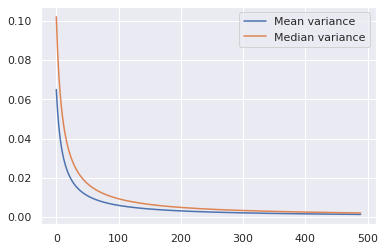

In [14]:

mean_vars = []
median_vars = []
for n in range (10, 500):
    N = n*10
    mean_vars.append(d**2/N) #дисперсия выборочного среднего для выборки размера N
    median_vars.append(np.pi*d**2/(2*N)) #дисперсия выборочной медианы для выборки размера N
plt.plot(mean_vars)
plt.plot(median_vars)
plt.legend(["Mean variance","Median variance"])



<font size=15>Можно заметить, что выбросы гораздо меньше влияют на смещение медианы относительно $a$, чем на смещение выборочного среднего относительно $a$. Однако, дисперсия выборочной медианы выше дисперсии выборочного среднего, и сходится в $\pi/2$ раз медленнее (выборочная медиана менее эффективная оценка, чем выборочное среднее)</font>


## 3. Построим доверительный интервал для параметра $p$ распределения Бернулли

Выпишем решение неравенства относительно $p$:

$\frac{n}{n+z_{1-\alpha/2}^2}(\overline{x} + \frac{z_{1-\alpha/2}^2}{2n} - z_{1-\alpha/2}\sqrt{\frac{\overline{x}(1-\overline{x})}{n})+\frac{z_{1-\alpha/2}^2}{4n^2}}) < p < \frac{n}{n+z_{1-\alpha/2}^2}(\overline{x} + \frac{z_{1-\alpha/2}^2}{2n} + z_{1-\alpha/2}\sqrt{\frac{\overline{x}(1-\overline{x})}{n})+\frac{z_{1-\alpha/2}^2}{4n^2}})$

In [15]:
import scipy.stats as stats
def ci_bernouilli (alpha, n, x):
    z = stats.norm.ppf(1 - alpha / 2)
    
    fSub1 = z*np.sqrt(x*(1-x)/n + z**2/(4*n**2))

    ci_left = n/(n+z**2)*(x + z**2/(2*n) - fSub1)
    ci_right = n/(n+z**2)*(x + z**2/(2*n) + fSub1)

    return (ci_left, ci_right)

**Посмотрим ДИ для распределения Бернулли с p=1/2:**

In [18]:
sample = stats.bernoulli.rvs(0.5, size = 50)
ci_bernouilli(0.05, 50, sample.mean())

(0.4461084919274572, 0.5833261482812249)

In [19]:
sample = stats.bernoulli.rvs(0.5, size = 200)
ci_bernouilli(0.05, 200, sample.mean())

(0.3923305179997147, 0.5291771081104668)

In [20]:
sample = stats.bernoulli.rvs(0.5, size = 1500)
ci_bernouilli(0.05, 1500, sample.mean())

(0.47273462235201685, 0.5232755953708639)

Построенные ДИ содержат истинное значение параметра, и их ширина уменьшается с ростом $n$.

** Продемонстрируем правильность построения ДИ с помощью моделирования: **

In [192]:
import random

alpha = 0.05
trials = 10000

error_count = 0 

for x in range(0,trials):

    #сгенерируем выборку из распределения Бернулли со случайными параметром p и размером выборки
    exact_p = random.uniform(0.01, 0.99)
    sample_size = int(random.uniform(10,100))

    sample = scp.bernoulli.rvs(exact_p, size = sample_size)
    smean = sample.mean()

    ci = ci_bernouilli(alpha, sample_size, smean)

    if((exact_p > ci[1]) or (exact_p < ci[0])):
        error_count+=1

print(f"Ошибка: {error_count/trials}")

Ошибка: 0.046


Как видно, у нас только 46 непопаданий в построенный доверительный интервал (уровень ошибки 0.046 < $\alpha$)

## 4. Демонстрация выполнения теоремы Пуассона

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


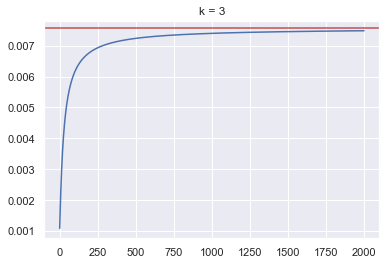

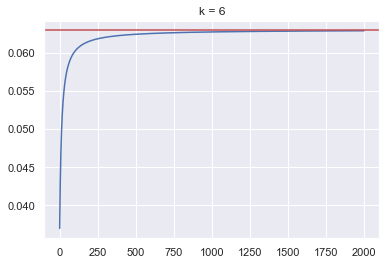

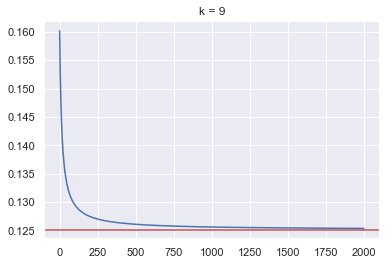

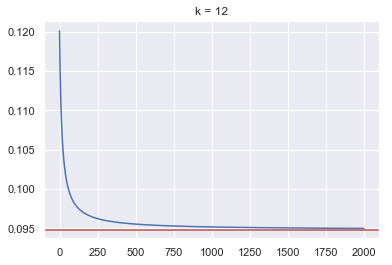

In [300]:
l = 10 #параметр распределения Пуассона
trials = 2000 #количество последовательностей с.в.
trial_range = range(0, trials)

errors = []

for k in range(1,5):
    exact_probs = np.zeros(trials)
    poisson_pred = stats.poisson.pmf(k = k*3, mu = l)

    for i in trial_range:
        pn = l/(i + 20)        #параметр p биномиального распределения
        exact_probs[i] = stats.binom.pmf(k = k*3, n = i + 20, p = pn)
        if(k == 3):
            errors.append(abs(exact_probs[i] - poisson_pred)) #для случая k=3 (для примера) также построим график абсолютного отклонения оценки параметра p от его истинного значения

    f = plt.figure(k)

    plt.title(f"k = {k*3}")
    plt.plot(trial_range, exact_probs)
    plt.axhline(y=poisson_pred, color='r', linestyle='-')
    
    f.show()

Ошибка в зависимости от n:


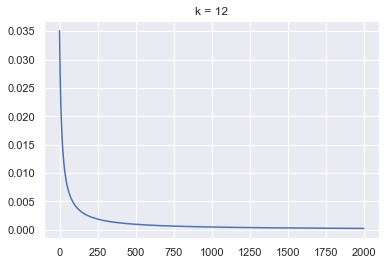

In [304]:
plt.title(f"k = {k*3}")
plt.plot(trial_range, errors)

Как видно, теорема Пуассона действительно выполняется.